# Factors that Affect Life Expectancy
Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

First, load the dataset.

Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

## Data Import and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
                    postgres_user, postgres_pw, postgres_host, 
                    postgres_port, postgres_db))

df = pd.read_sql_table(table_name, con=engine)

engine.dispose()
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [3]:
# what is the sum of NAN values
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [4]:
# noted white space in list above applying strip
df = df.rename(columns=lambda x: x.strip())
# what is the summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

In [5]:
# dataframe statistics
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Filling missing values
Looking at the charts above the majority of the missing values are based on variables that are unique to each country. The variables will be fill by interpolate based on a groupby country.

In [6]:
df = df.groupby('Country').apply(
    lambda x: x.interpolate(method='index', limit_direction=
                           'forward')).reset_index()

df.drop(['index'], axis=1, inplace=True)
# check to see if all values are filled
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            192
percentage expenditure               0
Hepatitis B                        144
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                                0
Total expenditure                  210
Diphtheria                           0
HIV/AIDS                             0
GDP                                422
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

**There are still a lot of missing values. An interpolate based on nearest values will be applied to fill remaining values.**

In [7]:
df = df.apply(lambda x: x.interpolate(
    method='nearest'))

df.isna().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
dtype: int64

In [8]:
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,69.195643,164.816542,30.303948,4.586727,738.251295,76.029272,2419.592240,38.310688,42.035739,82.307692,5.913018,82.075221,1.742103,7383.247144,1.229005e+07,4.881076,4.919231,0.634036,12.070354
std,4.613841,9.536654,124.433748,117.926501,4.049456,1987.914858,28.530933,11467.272489,20.139560,160.445548,23.636677,2.488779,23.917022,5.077785,13533.809763,5.520512e+07,4.475960,4.585113,0.210949,3.391935
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.025000,74.000000,0.000000,0.860000,4.685343,66.000000,0.000000,19.200000,0.000000,77.000000,4.260000,78.000000,0.100000,494.699711,1.779418e+05,1.600000,1.500000,0.499000,10.200000
50%,2008.000000,72.000000,144.000000,3.000000,3.705000,64.912906,89.000000,17.000000,43.500000,4.000000,93.000000,5.713904,93.000000,0.100000,1920.940038,1.412966e+06,3.400000,3.400000,0.684000,12.400000
75%,2012.000000,75.600000,228.000000,22.000000,7.665000,441.534144,96.000000,360.250000,56.300000,28.000000,97.000000,7.460000,97.000000,0.800000,6414.415157,7.280902e+06,7.200000,7.300000,0.791000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


## Outliers

In [9]:
variables = ['Year', 'Life expectancy', 'Adult Mortality', 'infant deaths', 
            'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles',
            'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years', 'Income composition of resources', 'Schooling']

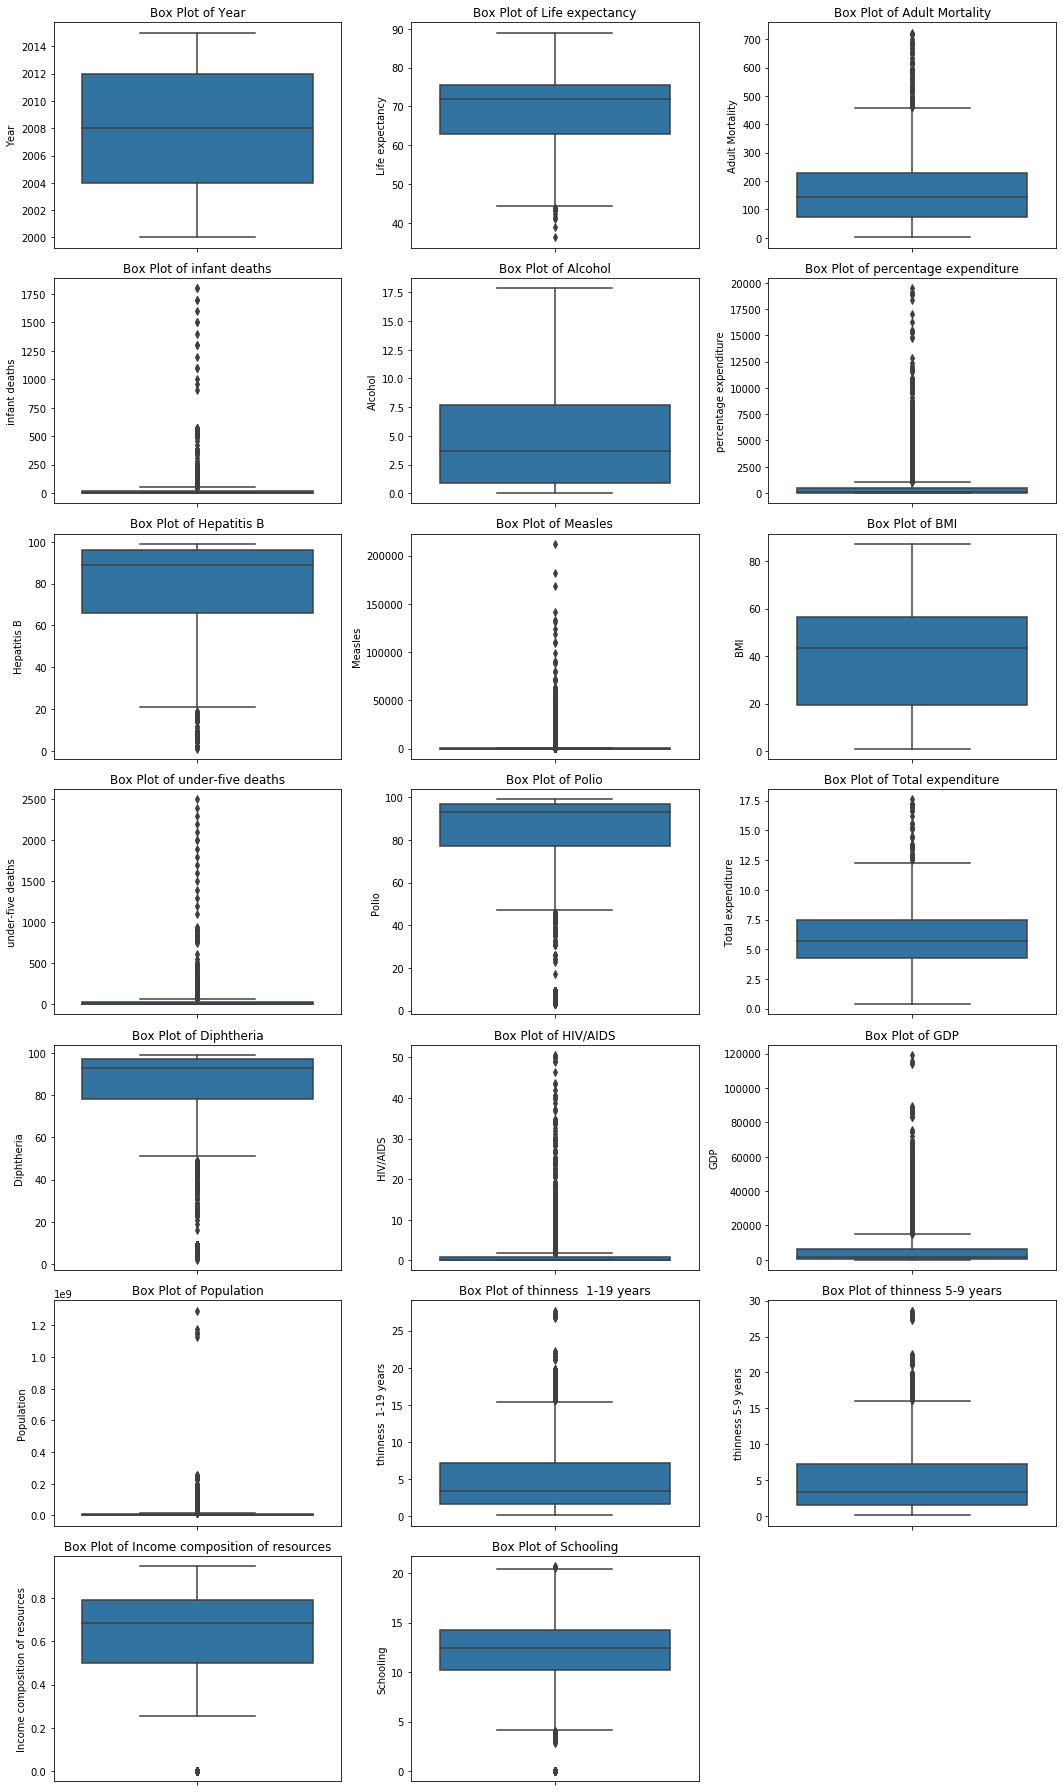

In [10]:
plt.figure(figsize=(15, 25))

i = 0
for variable in variables:
    i += 1
    plt.subplot(7, 3, i)
    sns.boxplot(df[variable], orient='v')
    plt.title('Box Plot of {}'.format(variable))
    
plt.tight_layout()
plt.show()

#### Analysis of chart
As shown in the charts above there is ouliers in each variable expect for year, alcohol, and BMI. The outliers can skew the descriptive statistics of the data. Furthermore, to get more accurate PCA results the outliers have to be dealt with. The data will be square rooted to transform the outliers.

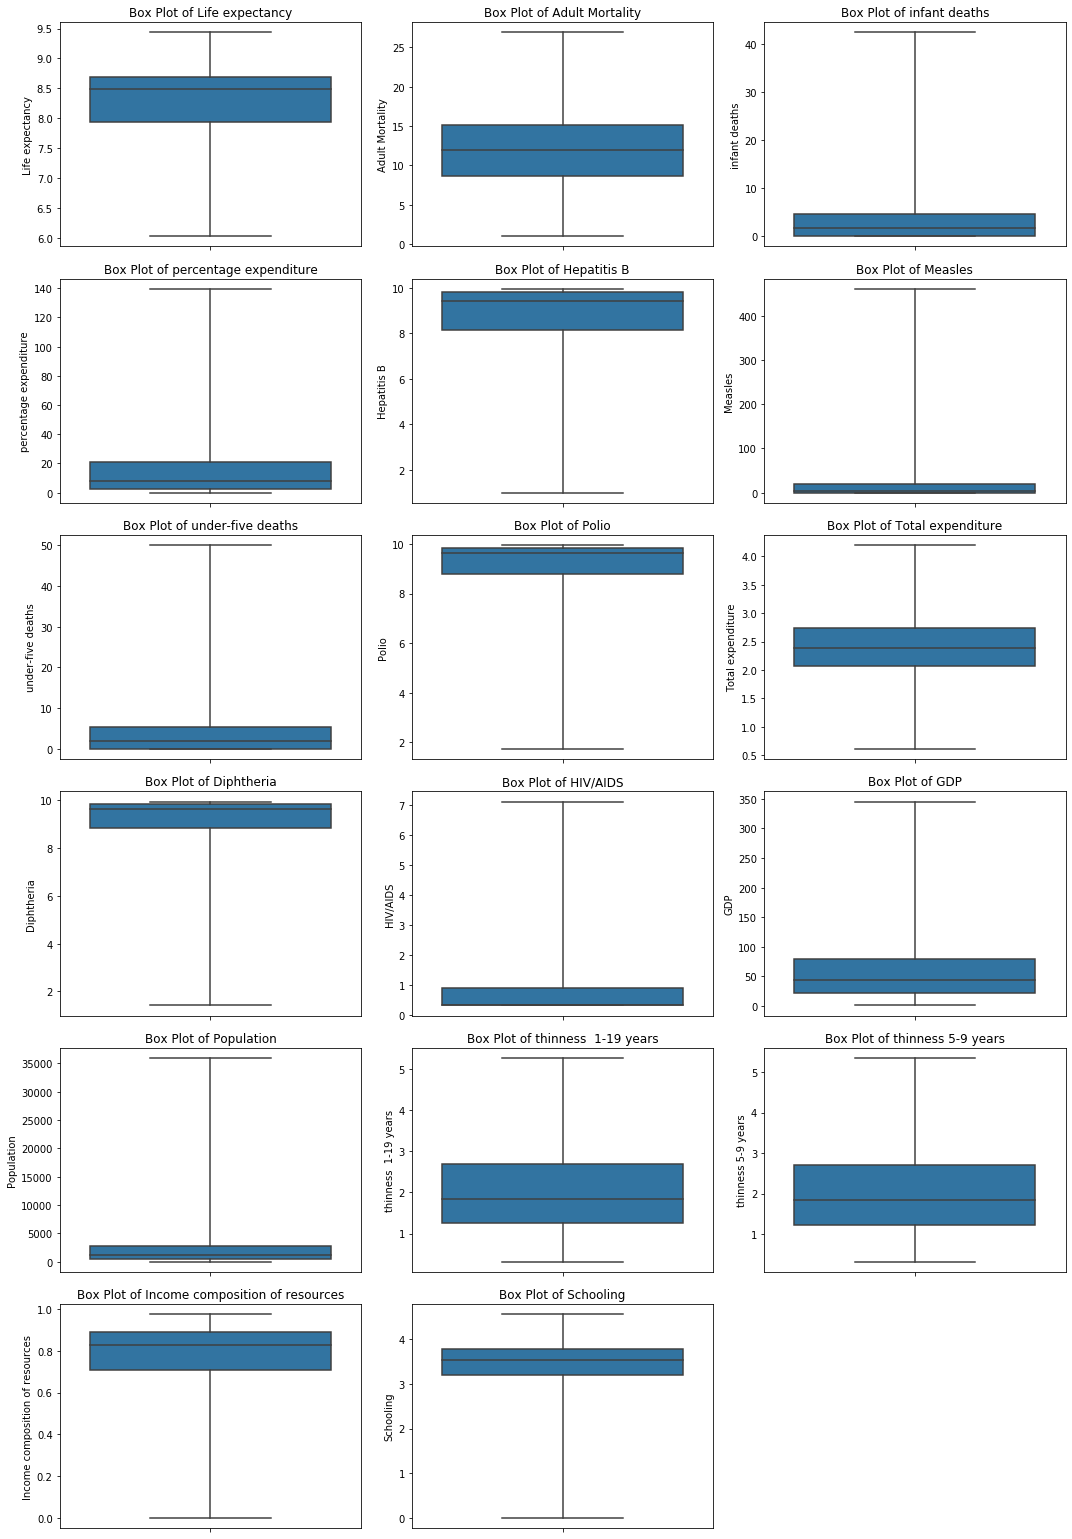

In [11]:
outliers = ['Life expectancy', 'Adult Mortality', 'infant deaths', 
            'percentage expenditure', 'Hepatitis B', 'Measles',
            'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
            'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 
            'thinness 5-9 years', 'Income composition of resources', 'Schooling']

df[outliers] = np.sqrt(df[outliers])


plt.figure(figsize=(15, 25))

i = 0
for variable in outliers:
    i += 1
    plt.subplot(7, 3, i)
    sns.boxplot(df[variable], orient='v', whis=25)
    plt.title('Box Plot of {}'.format(variable))
    
plt.tight_layout()
plt.show()

## Exploring the Data
The target variable is life expectancy.

In [12]:
avg_by_country = df.groupby('Country').mean().reset_index()
avg_by_country.head()

,Country,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2007.5,7.627021,15.978787,8.830607,0.014375,5.317740,8.034330,44.447196,15.51875,...,6.690949,2.870442,7.055041,0.316228,17.299626,2513.951686,3.961735,3.794514,0.643392,2.852616
1,Albania,2007.5,8.668663,5.965563,0.687500,4.848750,12.124279,9.899333,4.142880,49.06875,...,9.905712,2.437685,9.902563,0.316228,40.594724,617.020067,1.266891,1.299209,0.842274,3.478231
2,Algeria,2007.5,8.579688,9.958847,4.506299,0.610000,13.467410,8.603399,28.213913,48.74375,...,9.576527,2.149132,9.582990,0.316228,48.887859,4079.545252,2.468270,2.444080,0.833340,3.560736
3,Angola,2007.5,6.998646,17.650283,9.131385,5.397500,8.656969,8.447773,49.186112,18.01875,...,6.275267,1.966072,6.486929,1.537113,39.900099,2772.360925,2.327609,2.444589,0.676042,2.808684
4,Antigua and Barbuda,2007.5,8.663357,10.947278,0.000000,7.568125,27.350808,9.905663,0.000000,38.42500,...,9.844258,2.153312,9.915109,0.348974,94.619616,3935.880858,1.850371,1.836931,0.552620,2.350913


### Countries with highest and lowest life expectancy
Lets see which countries have the highest and lowest life expectancies. The top 5 countries are Japan, Sweden, Iceland, Switerland, and France. The bottom 5 countries are Sierra Leone, Niue, Saint Kitts and Nevis, Central African Republic, and Lesotho. 

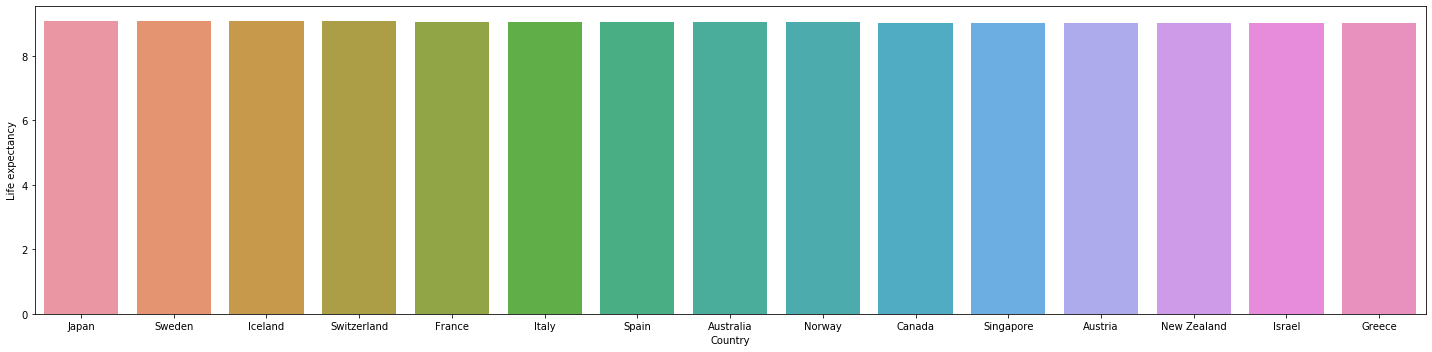

In [13]:
plt.figure(figsize=(20, 5))

# sort dataframe by largest values
avg_by_country.sort_values(['Life expectancy', 'Country'], 
                           inplace=True, axis=0, ascending=False)

sns.barplot(avg_by_country['Country'].head(15), 
            avg_by_country['Life expectancy'].head(15))

plt.tight_layout()
plt.show()

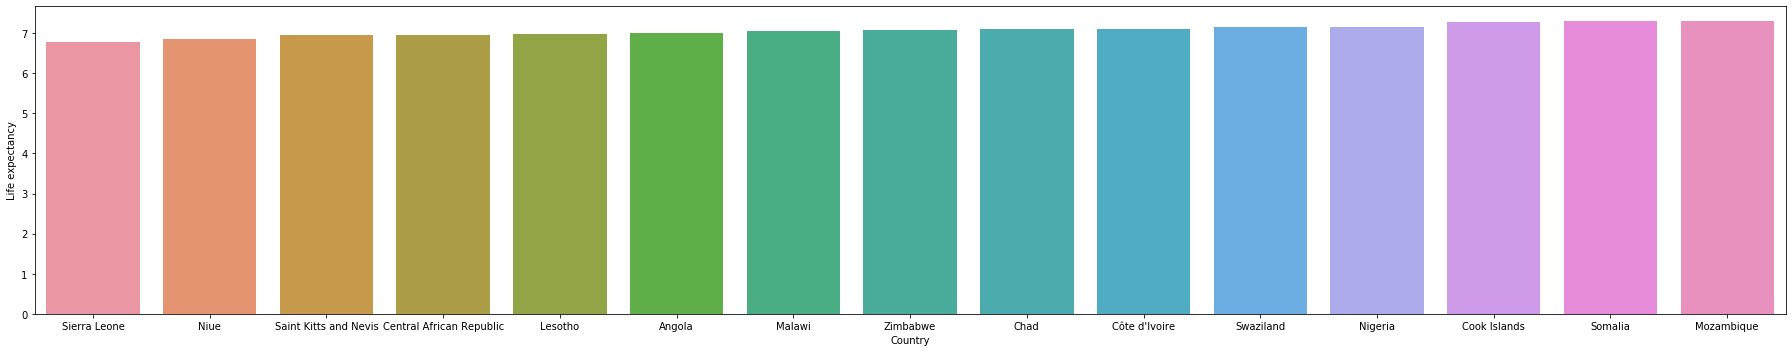

In [14]:
plt.figure(figsize=(25, 5))

# sort dataframe by smallest values
avg_by_country.sort_values(['Life expectancy', 'Country'],
                           inplace=True, axis=0, ascending=True)

sns.barplot(avg_by_country['Country'].head(15), 
            avg_by_country['Life expectancy'].head(15))

plt.tight_layout()
plt.show()

### Life Expectancy Correlation
The correlation of the different variables to life expectancy is plotted below. The biggest contributors for low life expectancy is adult mortality and HIV/AIDS; while the biggest contributors for high life expectancy is GDP and country's health percentage expenditure. 

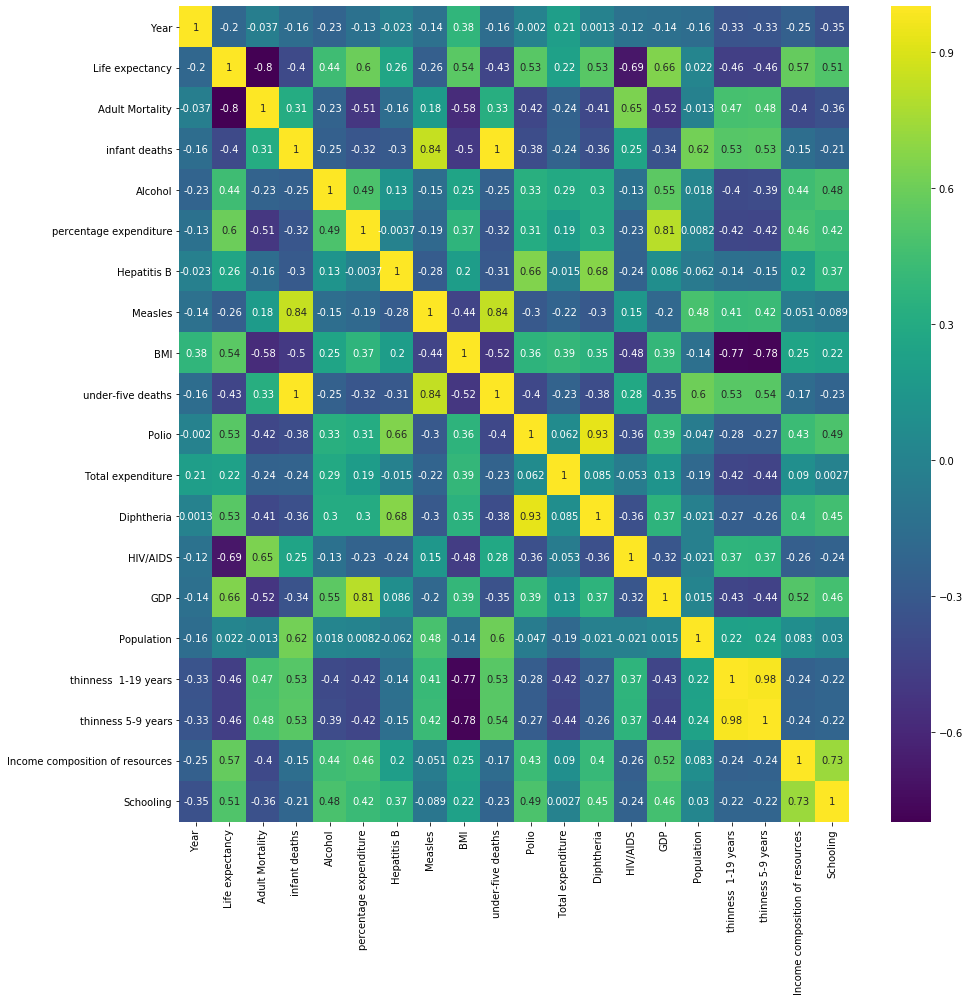

In [15]:
corr_life = avg_by_country.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_life, annot=True, cmap='viridis')

plt.show()

In [16]:
print(corr_life['Life expectancy'])

Year                              -0.204920
Life expectancy                    1.000000
Adult Mortality                   -0.797691
infant deaths                     -0.395641
Alcohol                            0.444487
percentage expenditure             0.599114
Hepatitis B                        0.257419
Measles                           -0.257617
BMI                                0.543178
under-five deaths                 -0.426220
Polio                              0.534448
Total expenditure                  0.221885
Diphtheria                         0.531285
HIV/AIDS                          -0.691668
GDP                                0.656415
Population                         0.022412
thinness  1-19 years              -0.463690
thinness 5-9 years                -0.463731
Income composition of resources    0.572995
Schooling                          0.505220
Name: Life expectancy, dtype: float64


### Dropping values
Looking at the correlations in the heatmap. Thinness is 98% correlated 1-19 years and 5-9 years. The 'thinness 5-9 years' will be dropped. Likewise Polio and Diptheria is 93% correlated and 'Diptheria' will be dropped.

In [19]:
remove_variables = ['Year', 'Diphtheria', 'thinness 5-9 years']

for item in remove_variables: 
    variables.remove(item)

print(variables)

['Life expectancy', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling']


### Scatterplot of Variable vs. Life Expectancy

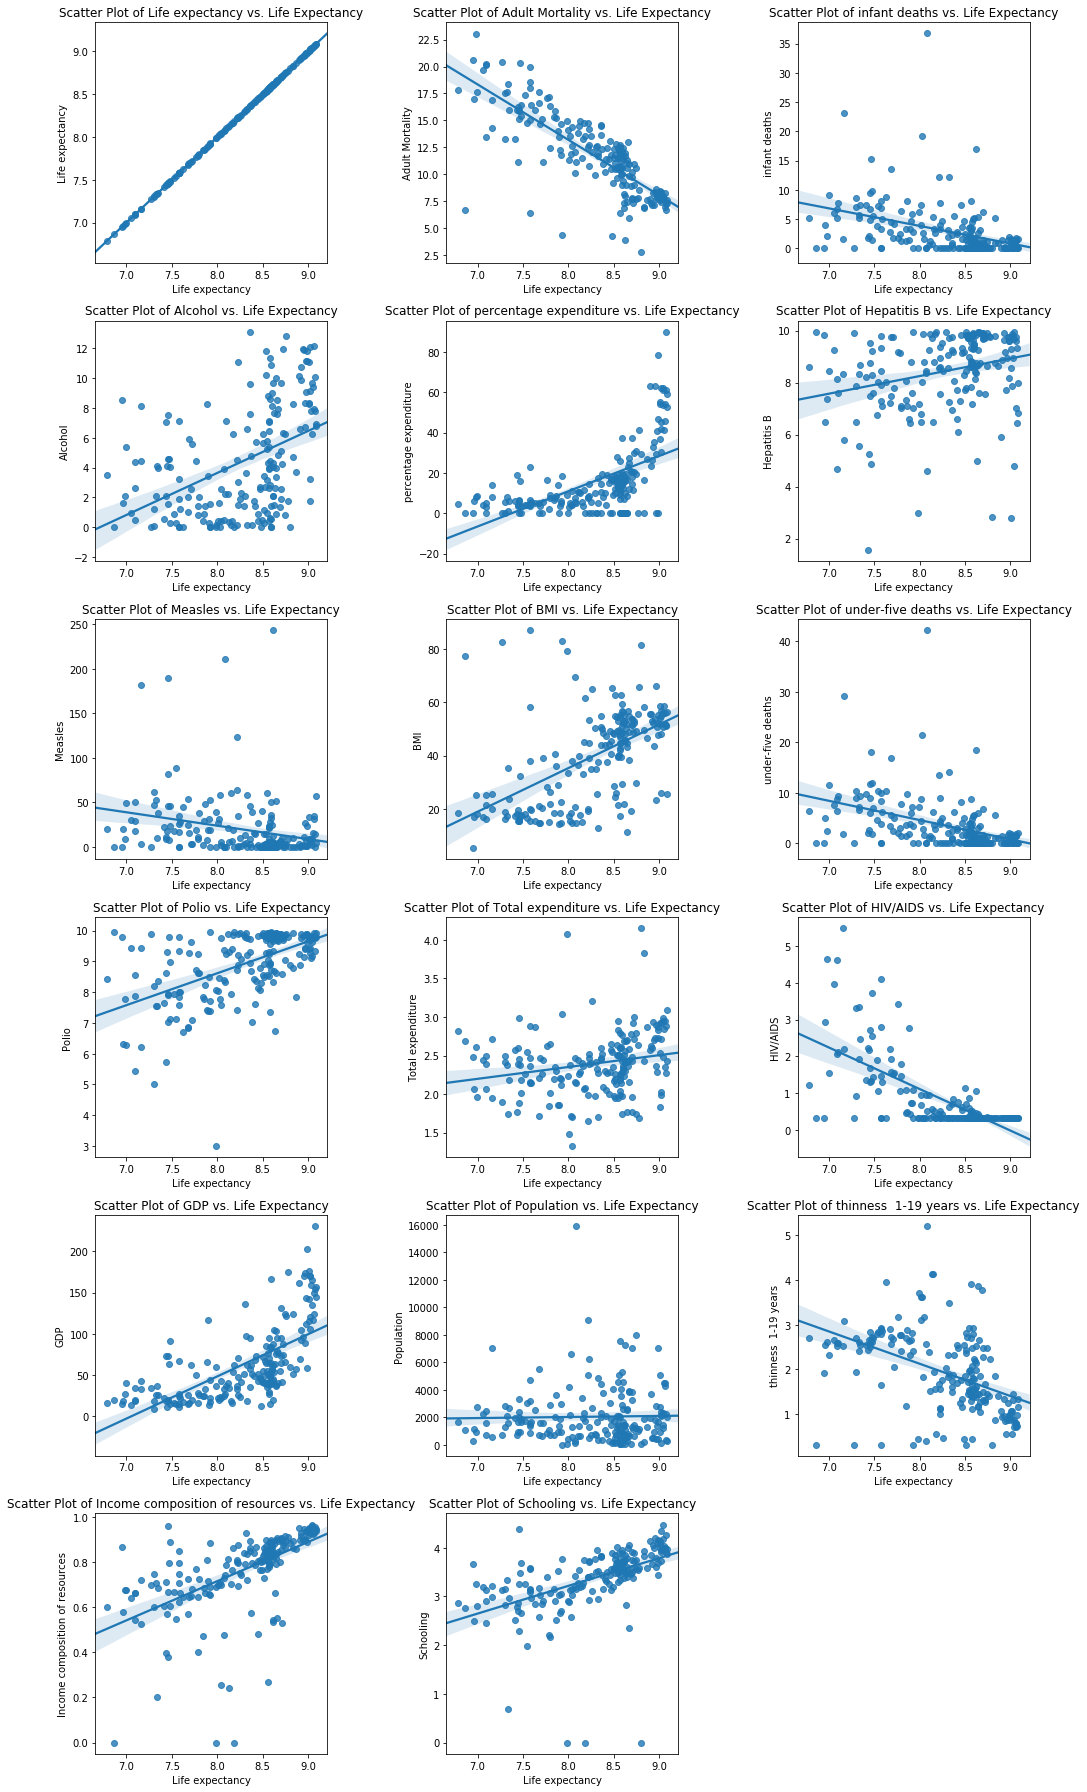

In [20]:
plt.figure(figsize=(15, 25))

i = 0
for variable in variables:
    i += 1
    plt.subplot(6, 3, i)
    sns.regplot(data=avg_by_country, y=variable, x='Life expectancy')
    plt.title('Scatter Plot of {} vs. Life Expectancy'.format(variable))
    
plt.tight_layout()
plt.show()

## Feature Engineering
PCA will be applied to the variables to reduce it from 17 variables to the ideal number of components. 

In [21]:
X = StandardScaler().fit_transform(avg_by_country[variables])

Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[ 0.32321018 -0.27851901 -0.27824915  0.21657307  0.25897851  0.15258782
 -0.22010973  0.28233625 -0.28502884  0.25141127  0.13499474 -0.22070073
  0.27857441 -0.09692767 -0.2764241   0.22341204  0.22453849]
Eigenvalue 1: 6.671135561880874
----------------------------------------
Eigenvector 2: 
[ 0.19160129 -0.15754652  0.37909273  0.1614044   0.18929171 -0.02819372
  0.40038596 -0.08700922  0.36759471  0.07656981 -0.11416811 -0.10769588
  0.20849139  0.4341703   0.1096788   0.29745646  0.25709092]
Eigenvalue 2: 2.7503367551326092
----------------------------------------
Eigenvector 3: 
[-0.0434454   0.15636473 -0.07922035 -0.06380488 -0.21584847  0.56890257
 -0.09382169 -0.22640599 -0.08598154  0.41609461 -0.37688551  0.01955992
 -0.13587791 -0.03684492  0.28124403  0.14527874  0.30005911]
Eigenvalue 3: 1.633224621301883
----------------------------------------
Eigenvector 4: 
[-0.17958311  0.33999243 -0.09863614  0.41381442  0.27105037 -0.17397789
 -0.0671968  -0.261

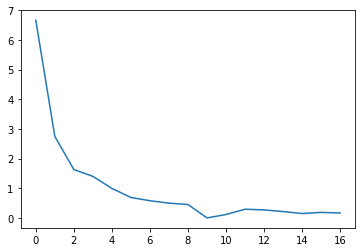

[6.67113556e+00 2.75033676e+00 1.63322462e+00 1.40433496e+00
 9.95855835e-01 6.91260741e-01 5.81500906e-01 4.99658130e-01
 4.53783404e-01 1.51293311e-03 1.17379001e-01 2.94826111e-01
 2.72013823e-01 2.15548442e-01 1.50371642e-01 1.87665700e-01
 1.68133103e-01]


In [22]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

In [23]:
# all components above 1 selected for PCA
sklearn_pca = PCA(n_components=4)
pca = sklearn_pca.fit_transform(X)


print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.39038648 0.16094625 0.09557425 0.08217992]


### Interpreting the PCA
Looking at the data above the PCA components above, 73% of the of the data variance is encompassed by 4 components.